## Initial Setup and Libraries

In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Preoprocessing and Data Cleaning

In [27]:
flight_data = pd.read_csv("flight_data.zip")

In [28]:
flight_data.drop(columns=['legId', 'searchDate', 'fareBasisCode', 'elapsedDays',
                          'segmentsDepartureTimeEpochSeconds', 'segmentsDepartureTimeRaw',
                          'segmentsArrivalTimeEpochSeconds', 'segmentsArrivalTimeRaw',
                          'segmentsArrivalAirportCode', 'segmentsDepartureAirportCode', 
                          'segmentsAirlineCode', 'totalFare'], inplace=True, errors='ignore')

flight_data.isnull().sum()

flightDate                          0
startingAirport                     0
destinationAirport                  0
travelDuration                      0
isBasicEconomy                      0
isRefundable                        0
isNonStop                           0
baseFare                            0
seatsRemaining                      0
totalTravelDistance             61860
segmentsAirlineName                 0
segmentsEquipmentDescription    18754
segmentsDurationInSeconds           0
segmentsDistance                 7724
segmentsCabinCode                   0
dtype: int64

In [29]:
flight_data['segmentsDistance'] = flight_data['segmentsDistance'].str.split(r'\|\|').str[0]
flight_data['segmentsDistance'].replace(['', 'None'], np.nan, inplace=True)
flight_data['segmentsDistance'] = pd.to_numeric(flight_data['segmentsDistance'], errors='coerce')
flight_data['segmentsDistance'].fillna(flight_data['segmentsDistance'].median(), inplace=True)

flight_data['segmentsAirlineName'] = flight_data['segmentsAirlineName'].str.split(r'\|\|').str[0]

flight_data = flight_data[flight_data['segmentsEquipmentDescription'].notnull()].reset_index(drop=True)

flight_data['totalTravelDistance'] = pd.to_numeric(flight_data['totalTravelDistance'], errors='coerce')
flight_data['totalTravelDistance'].fillna(flight_data['totalTravelDistance'].median(), inplace=True)


flight_data.isnull().sum()

/var/folders/yz/rt_zj8sn321f5zz639x4bnn40000gn/T/ipykernel_3935/3121845318.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  flight_data['segmentsDistance'].replace(['', 'None'], np.nan, inplace=True)
/var/folders/yz/rt_zj8sn321f5zz639x4bnn40000gn/T/ipykernel_3935/3121845318.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which w

flightDate                      0
startingAirport                 0
destinationAirport              0
travelDuration                  0
isBasicEconomy                  0
isRefundable                    0
isNonStop                       0
baseFare                        0
seatsRemaining                  0
totalTravelDistance             0
segmentsAirlineName             0
segmentsEquipmentDescription    0
segmentsDurationInSeconds       0
segmentsDistance                0
segmentsCabinCode               0
dtype: int64

In [30]:
flight_data = flight_data[flight_data['travelDuration'].notna()]
flight_data = flight_data[flight_data['travelDuration'].str.startswith('PT')]

flight_data = flight_data[flight_data['segmentsDurationInSeconds'].notna()]

In [31]:
def conversion(duration):
    try:
        if pd.isna(duration): return None
        match = re.match(r'PT(?:(\d+)H)?(?:(\d+)M)?', duration)
        hours = int(match.group(1)) if match.group(1) else 0
        minutes = int(match.group(2)) if match.group(2) else 0
        return hours * 60 + minutes
    except:
        return None

flight_data['travelDuration'] = flight_data['travelDuration'].apply(conversion)


def summation(value):
    try:
        if pd.isna(value): return None
        return sum(int(i) for i in value.split('||') if i.isdigit())
    except:
        return None

flight_data['segmentsDurationInSeconds'] = flight_data['segmentsDurationInSeconds'].apply(summation)
flight_data['segmentsDurationInSeconds'] = pd.to_numeric(flight_data['segmentsDurationInSeconds'], errors='coerce')



In [32]:
flight_data = flight_data[~flight_data['segmentsEquipmentDescription'].str.fullmatch(r'\|+', na=False)]

flight_data['segmentsEquipmentDescription'] = (flight_data['segmentsEquipmentDescription']
    .str.replace(r'^\|+', '', regex=True)  
    .str.replace(r'\|+$', '', regex=True)  
    .str.strip() 
)


In [33]:
flight_data['segmentsCabinCode'] = (flight_data['segmentsCabinCode'].str.split(r'\|\|').str[0].str.strip())

In [34]:
flight_data['flightDate'] = pd.to_datetime(flight_data['flightDate']).map(lambda x: x.toordinal())
flight_data.rename(columns = {'flightDate': 'flightDateOrdinal'}, inplace = True)

In [35]:
flight_data.to_csv('flight_data_preprocessed.csv.zip', index=False, compression='zip')

In [36]:
flight_data_cleaned = pd.read_csv("flight_data_preprocessed.csv.zip")

## Exploratory Data Analysis

In [37]:
categorical = ['startingAirport', 'destinationAirport', 'segmentsAirlineName',
               'segmentsEquipmentDescription', 'segmentsCabinCode']


onehot_encoding = pd.get_dummies(flight_data_cleaned, columns = categorical, drop_first = True)


label = flight_data_cleaned.copy()
label_encoding = {}
for col in categorical:
    encode = LabelEncoder()
    label[col] = encode.fit_transform(label[col])
    label_encoding[col] = encode

<Axes: >

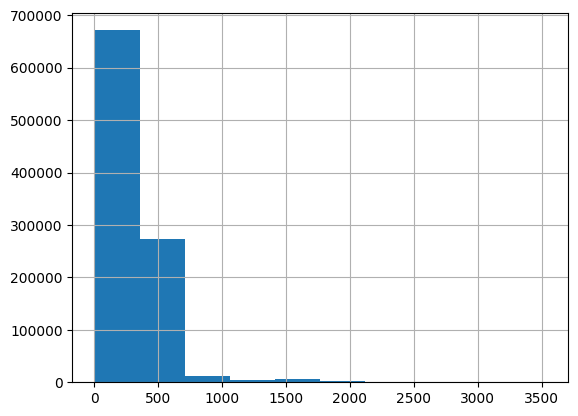

In [38]:
flight_data_cleaned['baseFare'].hist()

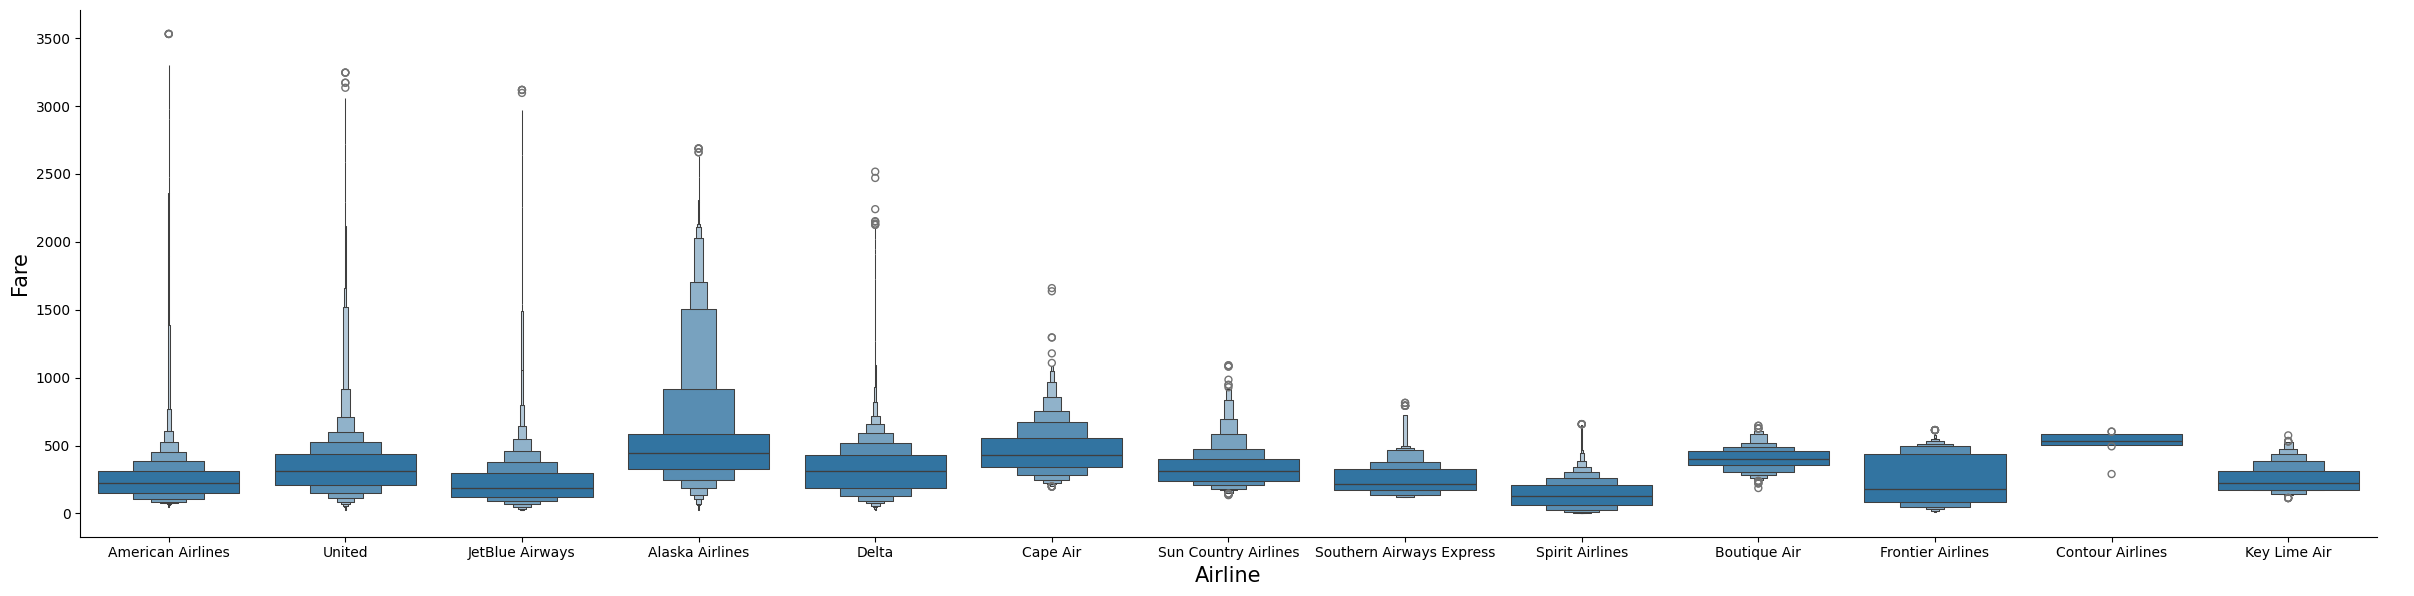

In [39]:
sns.catplot(y = 'baseFare', x = 'segmentsAirlineName', data = 
            flight_data_cleaned.sort_values('baseFare', ascending=False), 
            kind = 'boxen', height = 6, aspect = 4)
plt.xlabel('Airline', size = 15)
plt.ylabel('Fare', size = 15)
plt.show()

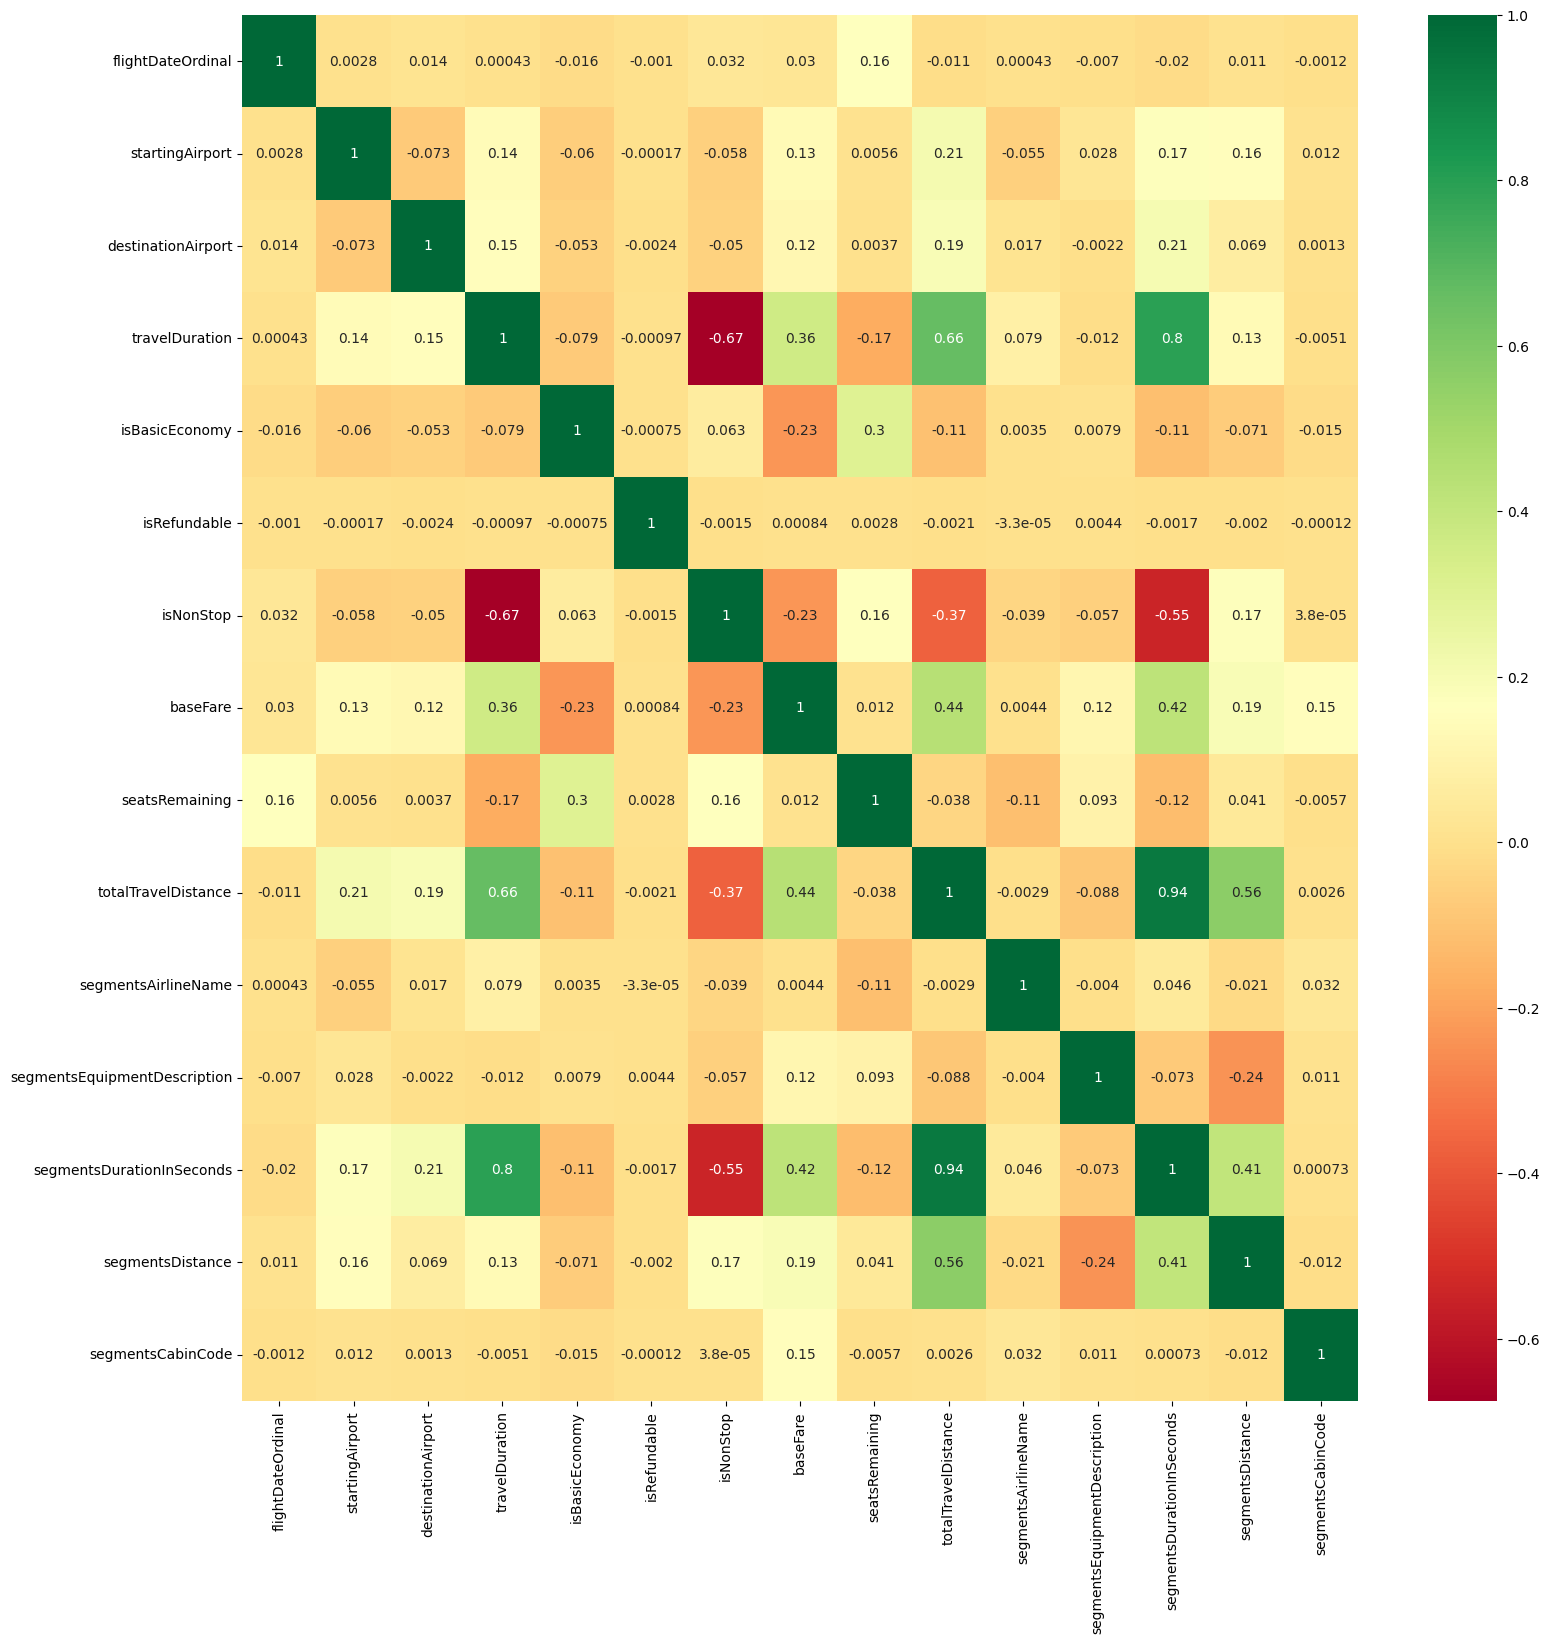

In [40]:
plt.figure(figsize = (18, 18))
sns.heatmap(label.corr(), annot = True, cmap = 'RdYlGn')
plt.show()

In [43]:
X = label.drop(columns = ['baseFare'])
y = label['baseFare']

model = ExtraTreesRegressor()
model.fit(X, y)

ExtraTreesRegressor()

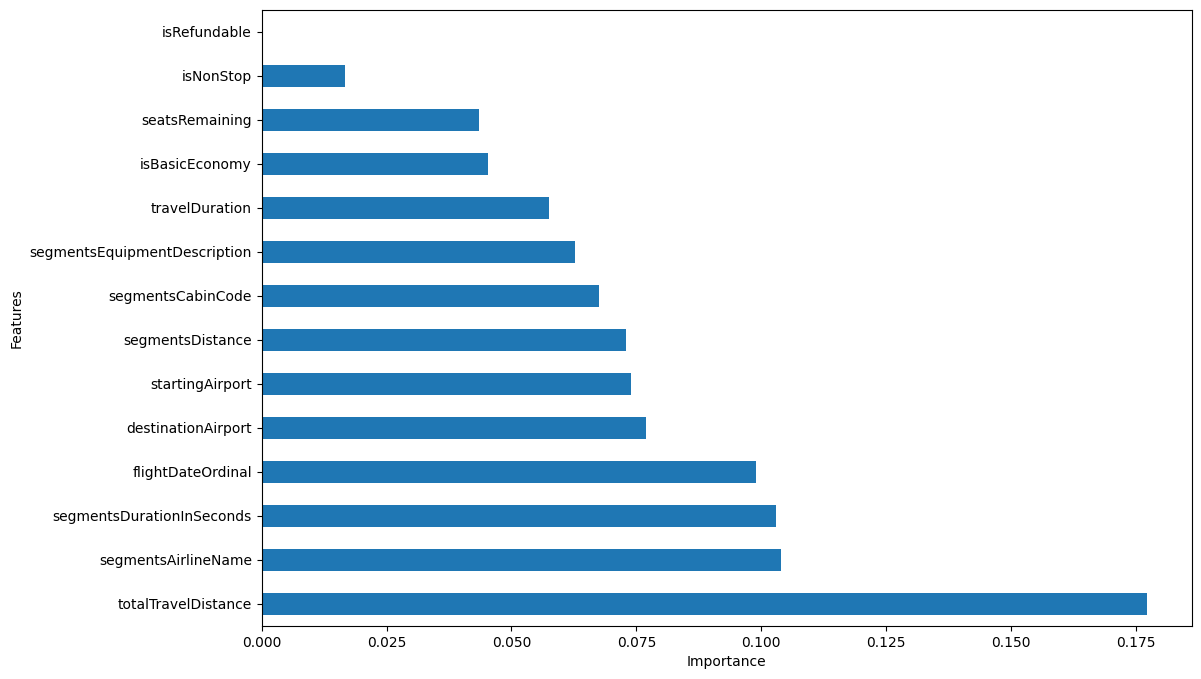

In [47]:
plt.figure(figsize = (12, 8))
feature_importance = pd.Series(model.feature_importances_, index = X.columns)
feature_importance.nlargest(15).plot(kind = 'barh')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

## Model Setup

In [49]:
"""
Important Features: 
- totalTravelDistance
- segmentsDurationInSeconds
- travelDuration
- flightDateOrdinal
- isBasicEconomy
- segmentsAirlineName
- startingAirport
- destinationAirport
- segmentsDistance
- segmentsCabinCode
"""

important_features = ['totalTravelDistance', 'segmentsDurationInSeconds', 'travelDuration',
                      'flightDateOrdinal', 'isBasicEconomy', 'segmentsAirlineName',
                      'startingAirport', 'destinationAirport', 'segmentsDistance',
                      'segmentsCabinCode']

In [52]:
X_linear = onehot_encoding[[col for col in onehot_encoding.columns if any(f in col for f in important_features)]]
y_linear = onehot_encoding['baseFare']

X_tree = label[important_features]
y_tree = label['baseFare']

In [53]:
X_train_linear, X_test_linear, y_train_linear, y_test_linear = train_test_split(X_linear, y_linear, test_size = 0.3, random_state = 42)
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X_tree, y_tree, test_size = 0.3, random_state = 42)

## Multiple Linear Regression

In [54]:
linear = LinearRegression()
linear.fit(X_train_linear, y_train_linear)
y_pred_linear = linear.predict(X_test_linear)

## Random Forest

In [55]:
randomForest = RandomForestRegressor(n_estimators = 100, random_state = 42, n_jobs = -1)
randomForest.fit(X_train_tree, y_train_tree)
y_pred_randomForest = randomForest.predict(X_test_tree)

## Gradient Boosting (XGBoosting)

In [57]:
xgb = XGBRegressor(n_estimators = 100, random_state = 42, n_jobs = -1)
xgb.fit(X_train_tree, y_train_tree)
y_pred_xgb = xgb.predict(X_test_tree)

## Model Performance

In [ ]:
print("Linear Regression")
print("MAE  :", (mean_absolute_error(y_test_linear, y_pred_linear)))
print("RMSE :", (mean_squared_error(y_test_linear, y_pred_linear, squared=False)))
print("R²   :", r2_score(y_test_linear, y_pred_linear))

print("")

print("Random Forest")
print("MAE  :", (mean_absolute_error(y_test_tree, y_pred_randomForest)))
print("RMSE :", (mean_squared_error(y_test_tree, y_pred_randomForest, squared=False)))
print("R²   :", r2_score(y_test_tree, y_pred_randomForest))

print("")

print("XGBoosting")
print("MAE  :", (mean_absolute_error(y_test_tree, y_pred_xgb)))
print("RMSE :", (mean_squared_error(y_test_tree, y_pred_xgb, squared=False)))
print("R²   :", r2_score(y_test_tree, y_pred_xgb))


📊 Linear Regression (70/30)
MAE  : 100.10
RMSE : 164.81
R²   : 0.4332

📊 Random Forest (70/30)
MAE  : 30.84
RMSE : 57.98
R²   : 0.9299

📊 XGBoost (70/30)
MAE  : 61.67
RMSE : 95.16
R²   : 0.8110


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Web Application Implementation